# Clasificador para estimar el espaciamiento espectral

- [x] Evolucionar la red neuronal a un clasificador basado en los mejores parámetros y probar con diferente número de clases (de 2 a 5 clases, como Alejandro).
- [ ] Añadir el caso sin tomar la OSNR como característica en clasificación.
- [x] Cambiar marcadores para que sean distinguibles FCM vs. GKM (Ser consistente para train y test).
- [ ] Graficar matrices de confusión.
- [ ] Añadir el caso sin tomar la OSNR como característica en regresión.
- [ ] Demodular usando redes neuronales (empezar con pocas neuronas y una sola capa oculta).

In [2]:
# Imports
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import (accuracy_score, f1_score, multilabel_confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from time import time

## Funciones globales

In [3]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

In [174]:
def plot_loss(score, end=500):
    """ Plot loss evolution for each k-fold. """
    for k, loss in enumerate(score["loss"]):
        loss_length = len(loss.history["loss"])
        loss_values = loss.history["loss"][:end if loss_length > end else loss_length]
        epoch_values = range(end if loss_length > end else loss_length)
        plt.plot(epoch_values, loss_values, label=f"k = {k+1}")

def plot_losses(scores, scenario, cmp_fn, cmp_values=[], end=500, based_on_index=False):
    """ Plot loss graphics for each scenario. """
    # Handle default cmp_values
    if len(cmp_values) == 0:
        cmp_values = np.zeros(len(scores))
        
    fig_loss = plt.figure(figsize=(16, 3*len(scores)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    
    for index, (score, cmps) in enumerate(zip(scores, cmp_values)):
        plt.subplot(len(scores)//2, 2, index + 1)
        plot_loss(score, end=end)
        
        plt.title(cmp_fn(cmps) if not based_on_index else cmp_fn(index))
        
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        # Transparent white box black edge legend
        legend = plt.legend(loc="upper right", edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))
        
        plt.grid(True)

def plot_scores(scores, x_values, scenario, score_names, data_type,
                label, xlabel, markers=[], colors=[], based_on_index=False,
                log=False, multiple_points=False, plot_train=True):
    fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        ax = plt.subplot(1, len(score_names), i+1)
        for dt in data_type:
            if not plot_train and dt == "train":
                continue
            points = [np.average(score[sn][dt]) for score in scores]
            if not multiple_points:
                label_value = ""
                plt.scatter(x_values, points, marker=markers[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(i)}", s=100)
            else:
                label_value = ""
                points1 = points[::2]
                points2 = points[1::2]
                plt.scatter(x_values, points1, marker=markers[0 if dt == "train" else 1],
                            color=colors[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(0)}", s=100)
                plt.scatter(x_values, points2, marker=markers[2 if dt == "train" else 3],
                            color=colors[2 if dt == "train" else 3],
                            label=f"{dt.title()} {label(1)}", s=100)
            title = ""
            if sn == "r2":
                title = "R²"
            elif sn == "acc":
                title = "Accuracy"
            else:
                title = sn.upper()
            plt.title(title)
                
        plt.xlabel(xlabel)
        # Adjust logarithmic scale if requested
        if log:
            plt.xscale("log", base=2)
            
        # Make integer xticks if matches}
        if type(x_values[0]) == np.int64:
            ax.set_xticks(x_values)
            
        if type(x_values[0]) == str:
            ax.set_xticks(range(len(x_values)), x_values)
            
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Transparent white box black edge legend
        legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                            edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))

        plt.grid(True)
        i += 1
    plt.show()

### Clasificación

In [4]:
def classificator(df, interval_lst, column_name):
    """Transforms a dataframe's column into classes"""
    array = df[column_name].to_numpy()
    indexes_lst = []
    for i, interval in enumerate(interval_lst):
        lower_limit, upper_limit = interval
        indexes_lst.append(np.intersect1d(np.where(lower_limit < array), np.where(array <= upper_limit)))
    
    classfull = df[column_name]
    for index, indexes in enumerate(indexes_lst):
        classfull[indexes] = index

    df_classfull = df.clone()
    df_classfull.replace(column_name, classfull)
    
    return df_classfull


def classifier_model(input_dim, layers_props_lst, classes_n, loss_fn):
    """ Compile a sequential model for classification purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Classifier
    model.add(ker.layers.Dense(units=classes_n, activation="softmax"))

    model.compile(loss=loss_fn, optimizer="adam")
    return model    


def classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks):
    """ Crossvalidation of a classification network. """
    # Store initial time
    t0 = time()

    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["acc"] = {"train": [], "test": []}
    scores["f1"] = {"train": [], "test": []}
    scores["cm"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = classifier_model(X_train.shape[1], layer_props, classes_n, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        fuzzy_predictions_train = model.predict(X_train)
        # Predict using test values
        fuzzy_predictions_test = model.predict(X_test_kf)
        
        # Assign class based on higher probability in membership vector
        predictions_train = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_train])
        predictions_test = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_test])

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Accuracy
        acc_score_train = accuracy_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        acc_score_test = accuracy_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # F1
        f1_score_train = f1_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            average="micro"
        )
        f1_score_test = f1_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            average="micro"
        )
         
        # Confusion Matrix
        cm_score_train = multilabel_confusion_matrix(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        cm_score_test = multilabel_confusion_matrix(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["acc"]["train"].append(acc_score_train)
        scores["acc"]["test"].append(acc_score_test)
        scores["f1"]["train"].append(f1_score_train)
        scores["f1"]["test"].append(f1_score_test)
        scores["cm"]["train"].append(cm_score_train)
        scores["cm"]["test"].append(cm_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_classification_model(data, n_splits, max_neurons, activations, classes_n, variables_n=17,
                              loss_fn="sparse_categorical_crossentropy"):
    """ Test a spectral overlapping classification model with given parameters. """

    # Split variables
    # Variables
    X = np.array(data[:, 0:variables_n]).T
    # Tags
    y = np.array(data[:, 19:20]).T
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=30, mode="min", restore_best_weights=True)
    ]
    
    return classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks)

def plot_classes_scores(scores, scenario):
    score_names = ["acc", "f1"]
    data_type = ["train", "test"]
    markers = ["o", "D", "o", "D"]
    colors = ["dodgerblue", "dodgerblue", "red", "red"]
    
    # Plot loss
    plot_losses(scores, scenario, 
                lambda index: f"{'FCM' if index%2==0 else 'GKM'} {'B2B' if index<2 else 'optical fiber at ' + ('0' if index<4 else '9') + ' dBm'}",
                based_on_index=True)
    
    # Plot scores
    plot_scores(scores, ["B2B", "0 dBm", "9 dBm"], scenario, score_names,
                data_type, label=lambda index: f"{'FCM' if index%2==0 else 'GKM'}",
                xlabel="Scenario", markers=markers, colors=colors, multiple_points=True,
                based_on_index=True)
    plt.show()

## Restaurar variables

### Clasificación con 2 clases

In [6]:
%store -r scores_2classes_FCM_B2B
%store -r scores_2classes_GKM_B2B

%store -r scores_2classes_FCM_fiber0
%store -r scores_2classes_GKM_fiber0

%store -r scores_2classes_FCM_fiber9
%store -r scores_2classes_GKM_fiber9

### Clasificación con 3 clases

In [7]:
%store -r scores_3classes_FCM_B2B
%store -r scores_3classes_GKM_B2B

%store -r scores_3classes_FCM_fiber0
%store -r scores_3classes_GKM_fiber0

%store -r scores_3classes_FCM_fiber9
%store -r scores_3classes_GKM_fiber9

### Clasificación con 4 clases

In [8]:
%store -r scores_4classes_FCM_B2B
%store -r scores_4classes_GKM_B2B

%store -r scores_4classes_FCM_fiber0
%store -r scores_4classes_GKM_fiber0

%store -r scores_4classes_FCM_fiber9
%store -r scores_4classes_GKM_fiber9

### Clasificación con 5 clases

In [9]:
%store -r scores_5classes_FCM_B2B
%store -r scores_5classes_GKM_B2B

%store -r scores_5classes_FCM_fiber0
%store -r scores_5classes_GKM_fiber0

%store -r scores_5classes_FCM_fiber9
%store -r scores_5classes_GKM_fiber9

## Cargar los datos

### FCM

In [10]:
data_file_FCM = "../Databases/CaractFCM.csv"
df_FCM = pl.read_csv(data_file_FCM, dtypes=[pl.Float64], has_header=False)

### GKM

In [11]:
data_file_GKM = "../Databases/CaractGKM.csv"
df_GKM = pl.read_csv(data_file_GKM, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Clasificador

## 2 clases

### FCM

In [12]:
interval_lst = [(0, 35), (35, 50)]
df_2classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_2classes_FCM_B2B = df_2classes_FCM[0:987, :]
# 0dBm optical fiber
df_2classes_FCM_fiber0 = df_2classes_FCM[988:1520, :]
# 9dBm optical fiber
df_2classes_FCM_fiber9 = df_2classes_FCM[1521:, :]

#### B2B

In [132]:
args = {"data": df_2classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_B2B = calc_once("scores_2classes_FCM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 125
7/7 [==============================] - 0s 1ms/step
Needed iterations: 561
7/7 [==============================] - 0s 908us/step
Needed iterations: 82
7/7 [==============================] - 0s 872us/step
Needed iterations: 195
7/7 [==============================] - 0s 976us/step
Needed iterations: 180
7/7 [==============================] - 0s 804us/step
Time elapsed: 0.30 minutes


#### Fibra óptica a 0dBm

In [133]:
args = {"data": df_2classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_fiber0 = calc_once("scores_2classes_FCM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 351
4/4 [==============================] - 0s 989us/step
Needed iterations: 450
4/4 [==============================] - 0s 2ms/step
Needed iterations: 444
4/4 [==============================] - 0s 934us/step
Needed iterations: 337
4/4 [==============================] - 0s 1ms/step
Needed iterations: 423
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.30 minutes


#### Fibra óptica a 9dBm

In [134]:
args = {"data": df_2classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_fiber9 = calc_once("scores_2classes_FCM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 210
6/6 [==============================] - 0s 1ms/step
Needed iterations: 173
6/6 [==============================] - 0s 1ms/step
Needed iterations: 218
6/6 [==============================] - 0s 860us/step
Needed iterations: 166
6/6 [==============================] - 0s 918us/step
Needed iterations: 254
6/6 [==============================] - 0s 878us/step
Time elapsed: 0.24 minutes


### GKM

In [135]:
interval_lst = [(0, 35), (35, 50)]
df_2classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_2classes_GKM_B2B = df_2classes_GKM[0:987, :]
# 0dBm optical fiber
df_2classes_GKM_fiber0 = df_2classes_GKM[988:1520, :]
# 9dBm optical fiber
df_2classes_GKM_fiber9 = df_2classes_GKM[1521:, :]

#### B2B

In [136]:
args = {"data": df_2classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_B2B = calc_once("scores_2classes_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 579
7/7 [==============================] - 0s 768us/step
Needed iterations: 394
7/7 [==============================] - 0s 776us/step
Needed iterations: 463
7/7 [==============================] - 0s 858us/step
Needed iterations: 154
7/7 [==============================] - 0s 1ms/step
Needed iterations: 445
7/7 [==============================] - 0s 1ms/step
Time elapsed: 0.44 minutes


#### Fibra óptica a 0dBm

In [137]:
args = {"data": df_2classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_fiber0 = calc_once("scores_2classes_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 413
4/4 [==============================] - 0s 1ms/step
Needed iterations: 712
4/4 [==============================] - 0s 879us/step
Needed iterations: 742
4/4 [==============================] - 0s 1ms/step
Needed iterations: 702
4/4 [==============================] - 0s 1ms/step
Needed iterations: 339
4/4 [==============================] - 0s 908us/step
Time elapsed: 0.37 minutes


#### Fibra óptica a 9dBm

In [138]:
args = {"data": df_2classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_fiber9 = calc_once("scores_2classes_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 181
6/6 [==============================] - 0s 813us/step
Needed iterations: 175
6/6 [==============================] - 0s 4ms/step
Needed iterations: 96
6/6 [==============================] - 0s 820us/step
Needed iterations: 132
6/6 [==============================] - 0s 890us/step
Needed iterations: 142
6/6 [==============================] - 0s 1ms/step
Time elapsed: 0.20 minutes


In [139]:
%store scores_2classes_FCM_B2B
%store scores_2classes_GKM_B2B
%store scores_2classes_FCM_fiber0
%store scores_2classes_GKM_fiber0
%store scores_2classes_FCM_fiber9
%store scores_2classes_GKM_fiber9

Stored 'scores_2classes_FCM_B2B' (dict)
Stored 'scores_2classes_GKM_B2B' (dict)
Stored 'scores_2classes_FCM_fiber0' (dict)
Stored 'scores_2classes_GKM_fiber0' (dict)
Stored 'scores_2classes_FCM_fiber9' (dict)
Stored 'scores_2classes_GKM_fiber9' (dict)


### Gráficas

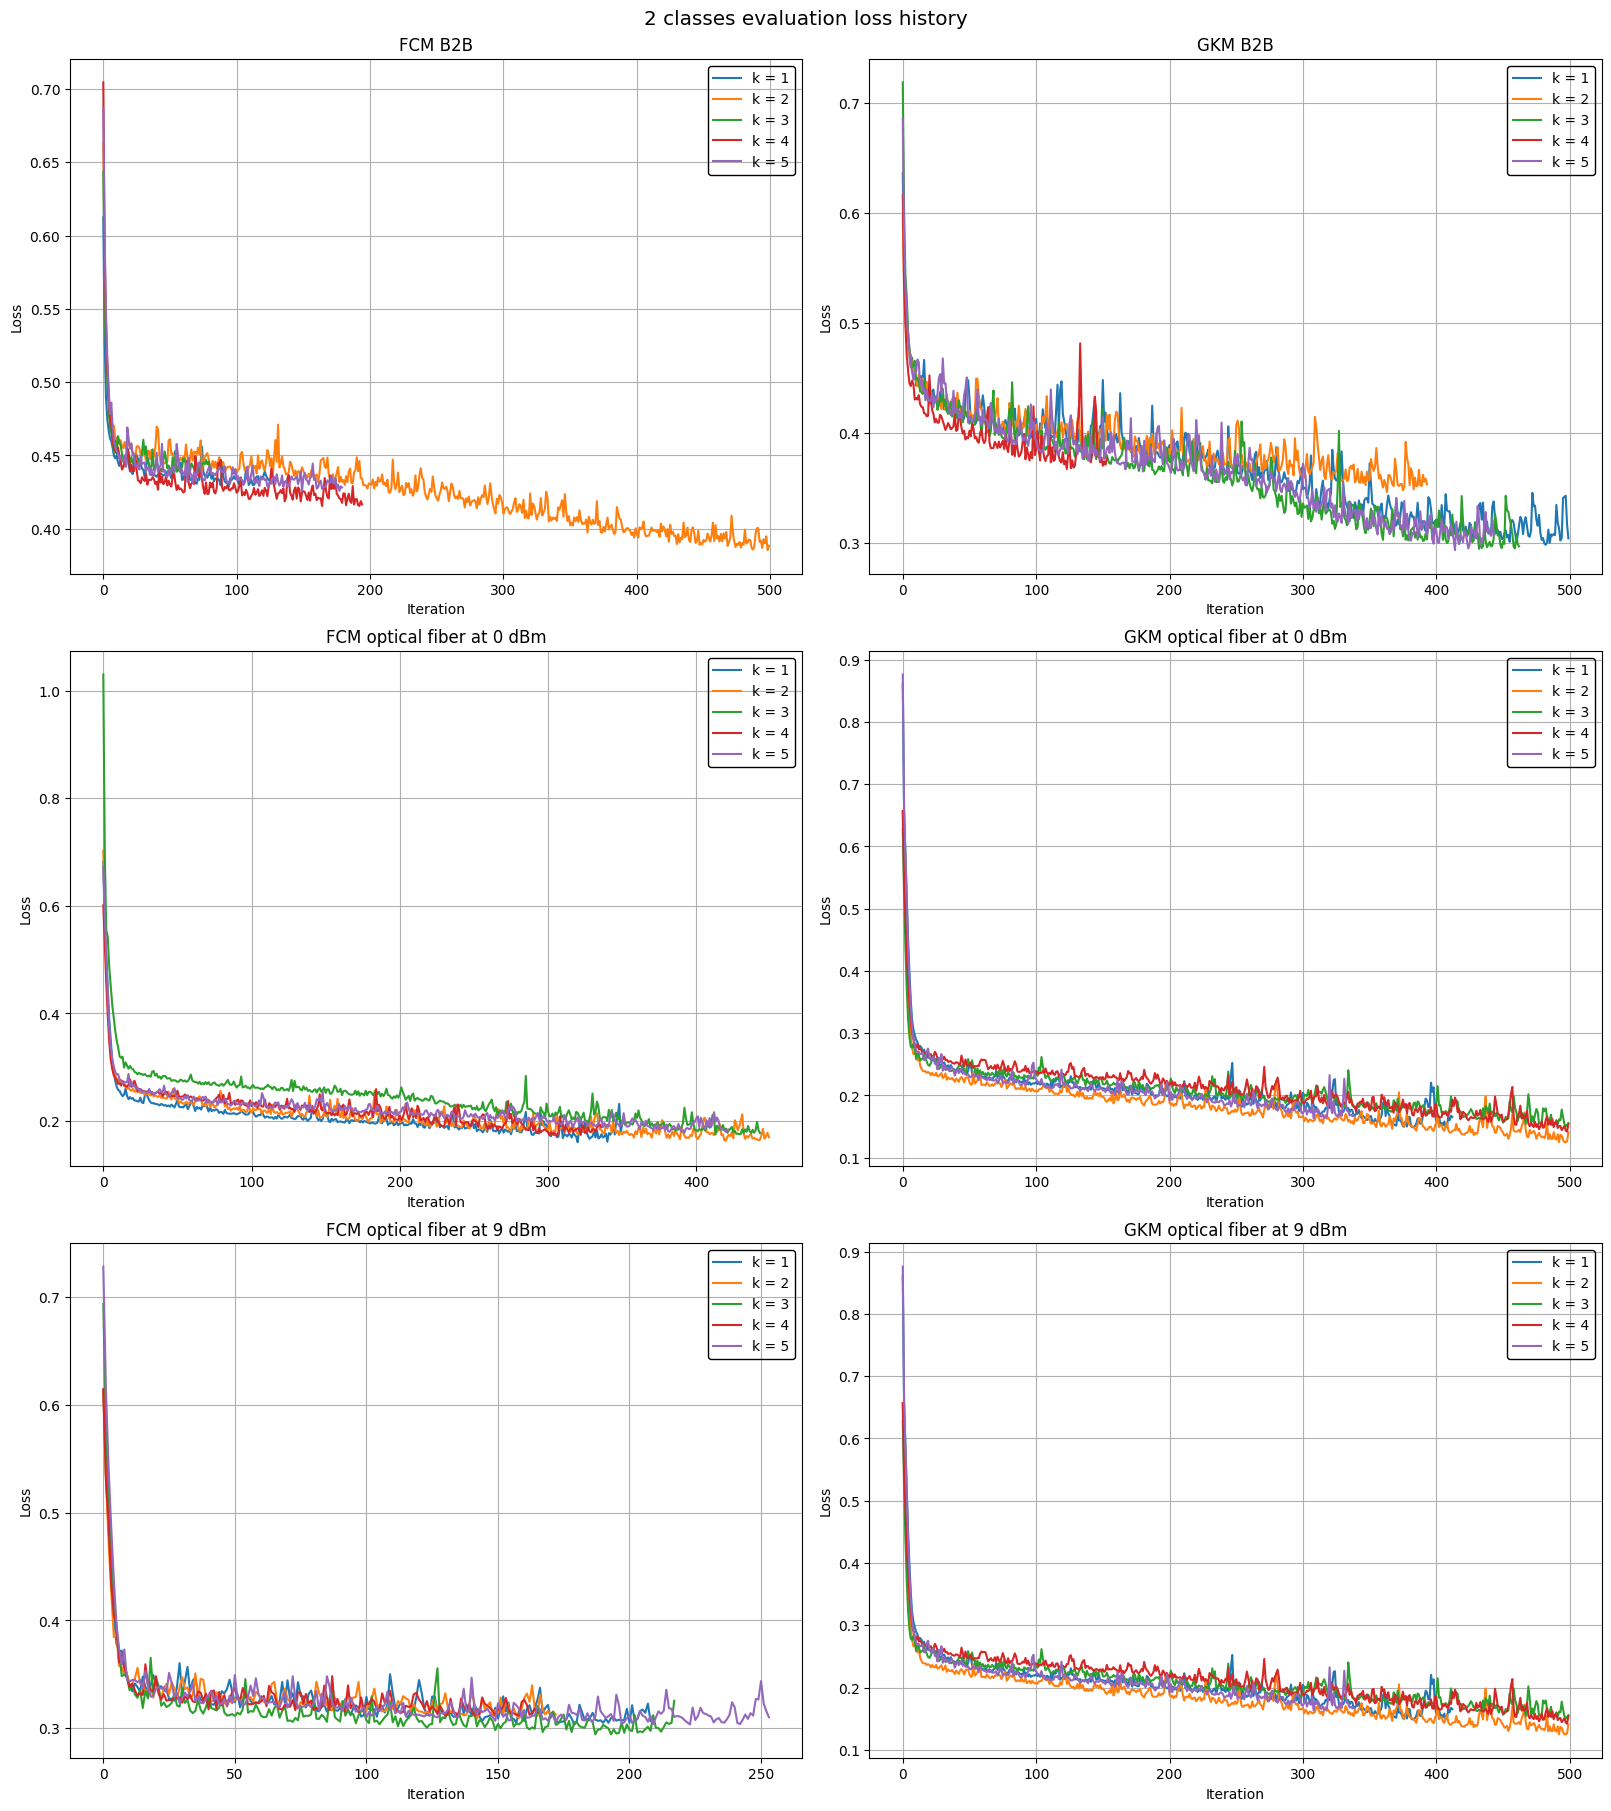

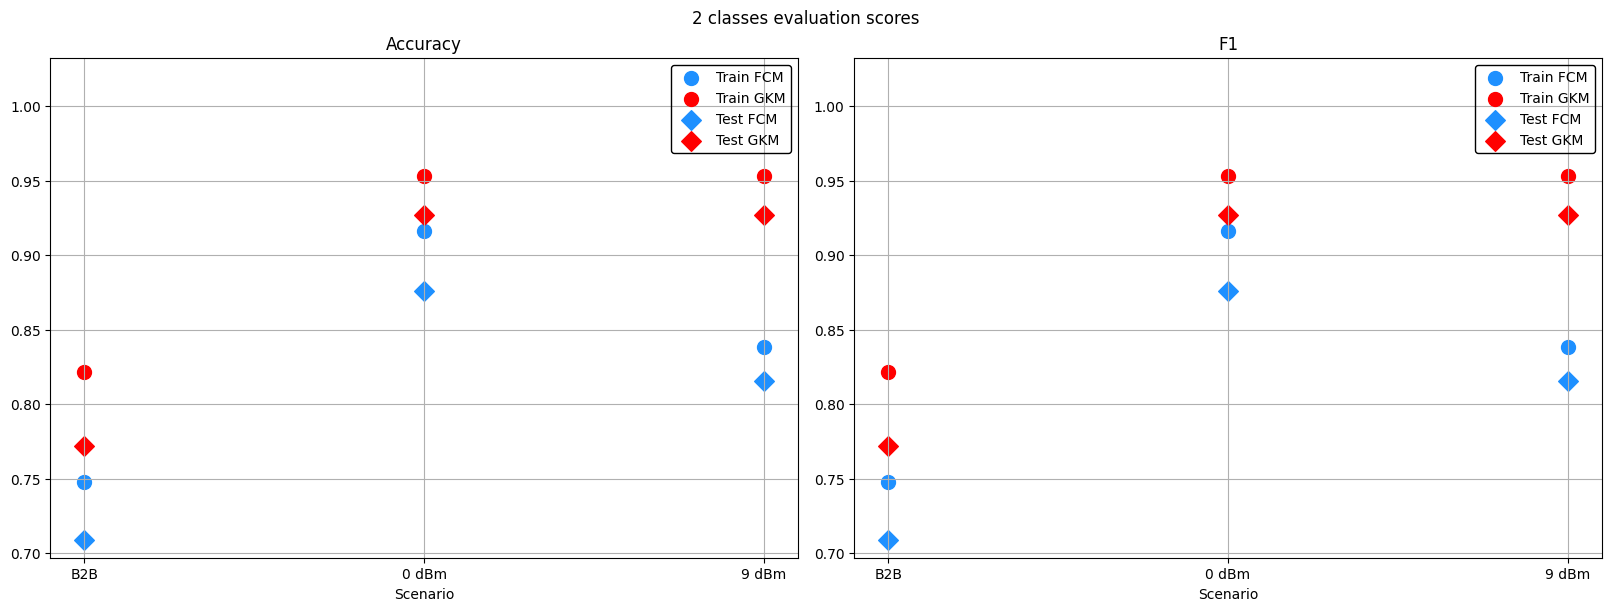

In [140]:
scores = [scores_2classes_FCM_B2B, scores_2classes_GKM_B2B, scores_2classes_FCM_fiber0, scores_2classes_GKM_fiber0, scores_2classes_FCM_fiber9, scores_2classes_GKM_fiber0]
plot_classes_scores(scores, "2 classes evaluation")

## 3 clases

### FCM

In [141]:
interval_lst = [(0, 32), (32, 35), (35, 50)]
df_3classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_3classes_FCM_B2B = df_3classes_FCM[0:987, :]
# 0dBm optical fiber
df_3classes_FCM_fiber0 = df_3classes_FCM[988:1520, :]
# 9dBm optical fiber
df_3classes_FCM_fiber9 = df_3classes_FCM[1521:, :]

#### B2B

In [142]:
args = {"data": df_3classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_B2B = calc_once("scores_3classes_FCM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 889
7/7 [==============================] - 0s 1ms/step
Needed iterations: 721
7/7 [==============================] - 0s 1ms/step
Needed iterations: 464
7/7 [==============================] - 0s 788us/step
Needed iterations: 660
7/7 [==============================] - 0s 716us/step
Needed iterations: 971
7/7 [==============================] - 0s 702us/step
Time elapsed: 0.81 minutes


#### Fibra óptica a 0dBm

In [143]:
args = {"data": df_3classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_fiber0 = calc_once("scores_3classes_FCM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 823
4/4 [==============================] - 0s 905us/step
Needed iterations: 819
4/4 [==============================] - 0s 980us/step
Needed iterations: 470
4/4 [==============================] - 0s 1ms/step
Needed iterations: 619
4/4 [==============================] - 0s 1ms/step
Needed iterations: 570
4/4 [==============================] - 0s 973us/step
Time elapsed: 0.45 minutes


#### Fibra óptica a 9dBm

In [144]:
args = {"data": df_3classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_fiber9 = calc_once("scores_3classes_FCM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 344
6/6 [==============================] - 0s 852us/step
Needed iterations: 149
6/6 [==============================] - 0s 859us/step
Needed iterations: 250
6/6 [==============================] - 0s 806us/step
Needed iterations: 374
6/6 [==============================] - 0s 1ms/step
Needed iterations: 360
6/6 [==============================] - 0s 879us/step
Time elapsed: 0.33 minutes


### GKM

In [145]:
interval_lst = [(0, 32), (32, 35), (35, 50)]
df_3classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_3classes_GKM_B2B = df_3classes_GKM[0:987, :]
# 0dBm optical fiber
df_3classes_GKM_fiber0 = df_3classes_GKM[988:1520, :]
# 9dBm optical fiber
df_3classes_GKM_fiber9 = df_3classes_GKM[1521:, :]

#### B2B

In [146]:
args = {"data": df_3classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_B2B = calc_once("scores_3classes_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 528
7/7 [==============================] - 0s 751us/step
Needed iterations: 439
7/7 [==============================] - 0s 835us/step
Needed iterations: 432
7/7 [==============================] - 0s 938us/step
Needed iterations: 458
7/7 [==============================] - 0s 818us/step
Needed iterations: 357
7/7 [==============================] - 0s 872us/step
Time elapsed: 0.51 minutes


#### Fibra óptica a 0dBm

In [147]:
args = {"data": df_3classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_fiber0 = calc_once("scores_3classes_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 991
4/4 [==============================] - 0s 1ms/step
Needed iterations: 979
4/4 [==============================] - 0s 866us/step
Needed iterations: 787
4/4 [==============================] - 0s 892us/step
Needed iterations: 713
4/4 [==============================] - 0s 1ms/step
Needed iterations: 859
4/4 [==============================] - 0s 2ms/step
Time elapsed: 0.56 minutes


#### Fibra óptica a 9dBm

In [148]:
args = {"data": df_3classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_fiber9 = calc_once("scores_3classes_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 109
6/6 [==============================] - 0s 1ms/step
Needed iterations: 106
6/6 [==============================] - 0s 1ms/step
Needed iterations: 187
6/6 [==============================] - 0s 942us/step
Needed iterations: 122
6/6 [==============================] - 0s 889us/step
Needed iterations: 265
6/6 [==============================] - 0s 1ms/step
Time elapsed: 0.21 minutes


In [149]:
%store scores_3classes_FCM_B2B
%store scores_3classes_GKM_B2B
%store scores_3classes_FCM_fiber0
%store scores_3classes_GKM_fiber0
%store scores_3classes_FCM_fiber9
%store scores_3classes_GKM_fiber9

Stored 'scores_3classes_FCM_B2B' (dict)
Stored 'scores_3classes_GKM_B2B' (dict)
Stored 'scores_3classes_FCM_fiber0' (dict)
Stored 'scores_3classes_GKM_fiber0' (dict)
Stored 'scores_3classes_FCM_fiber9' (dict)
Stored 'scores_3classes_GKM_fiber9' (dict)


### Gráficas

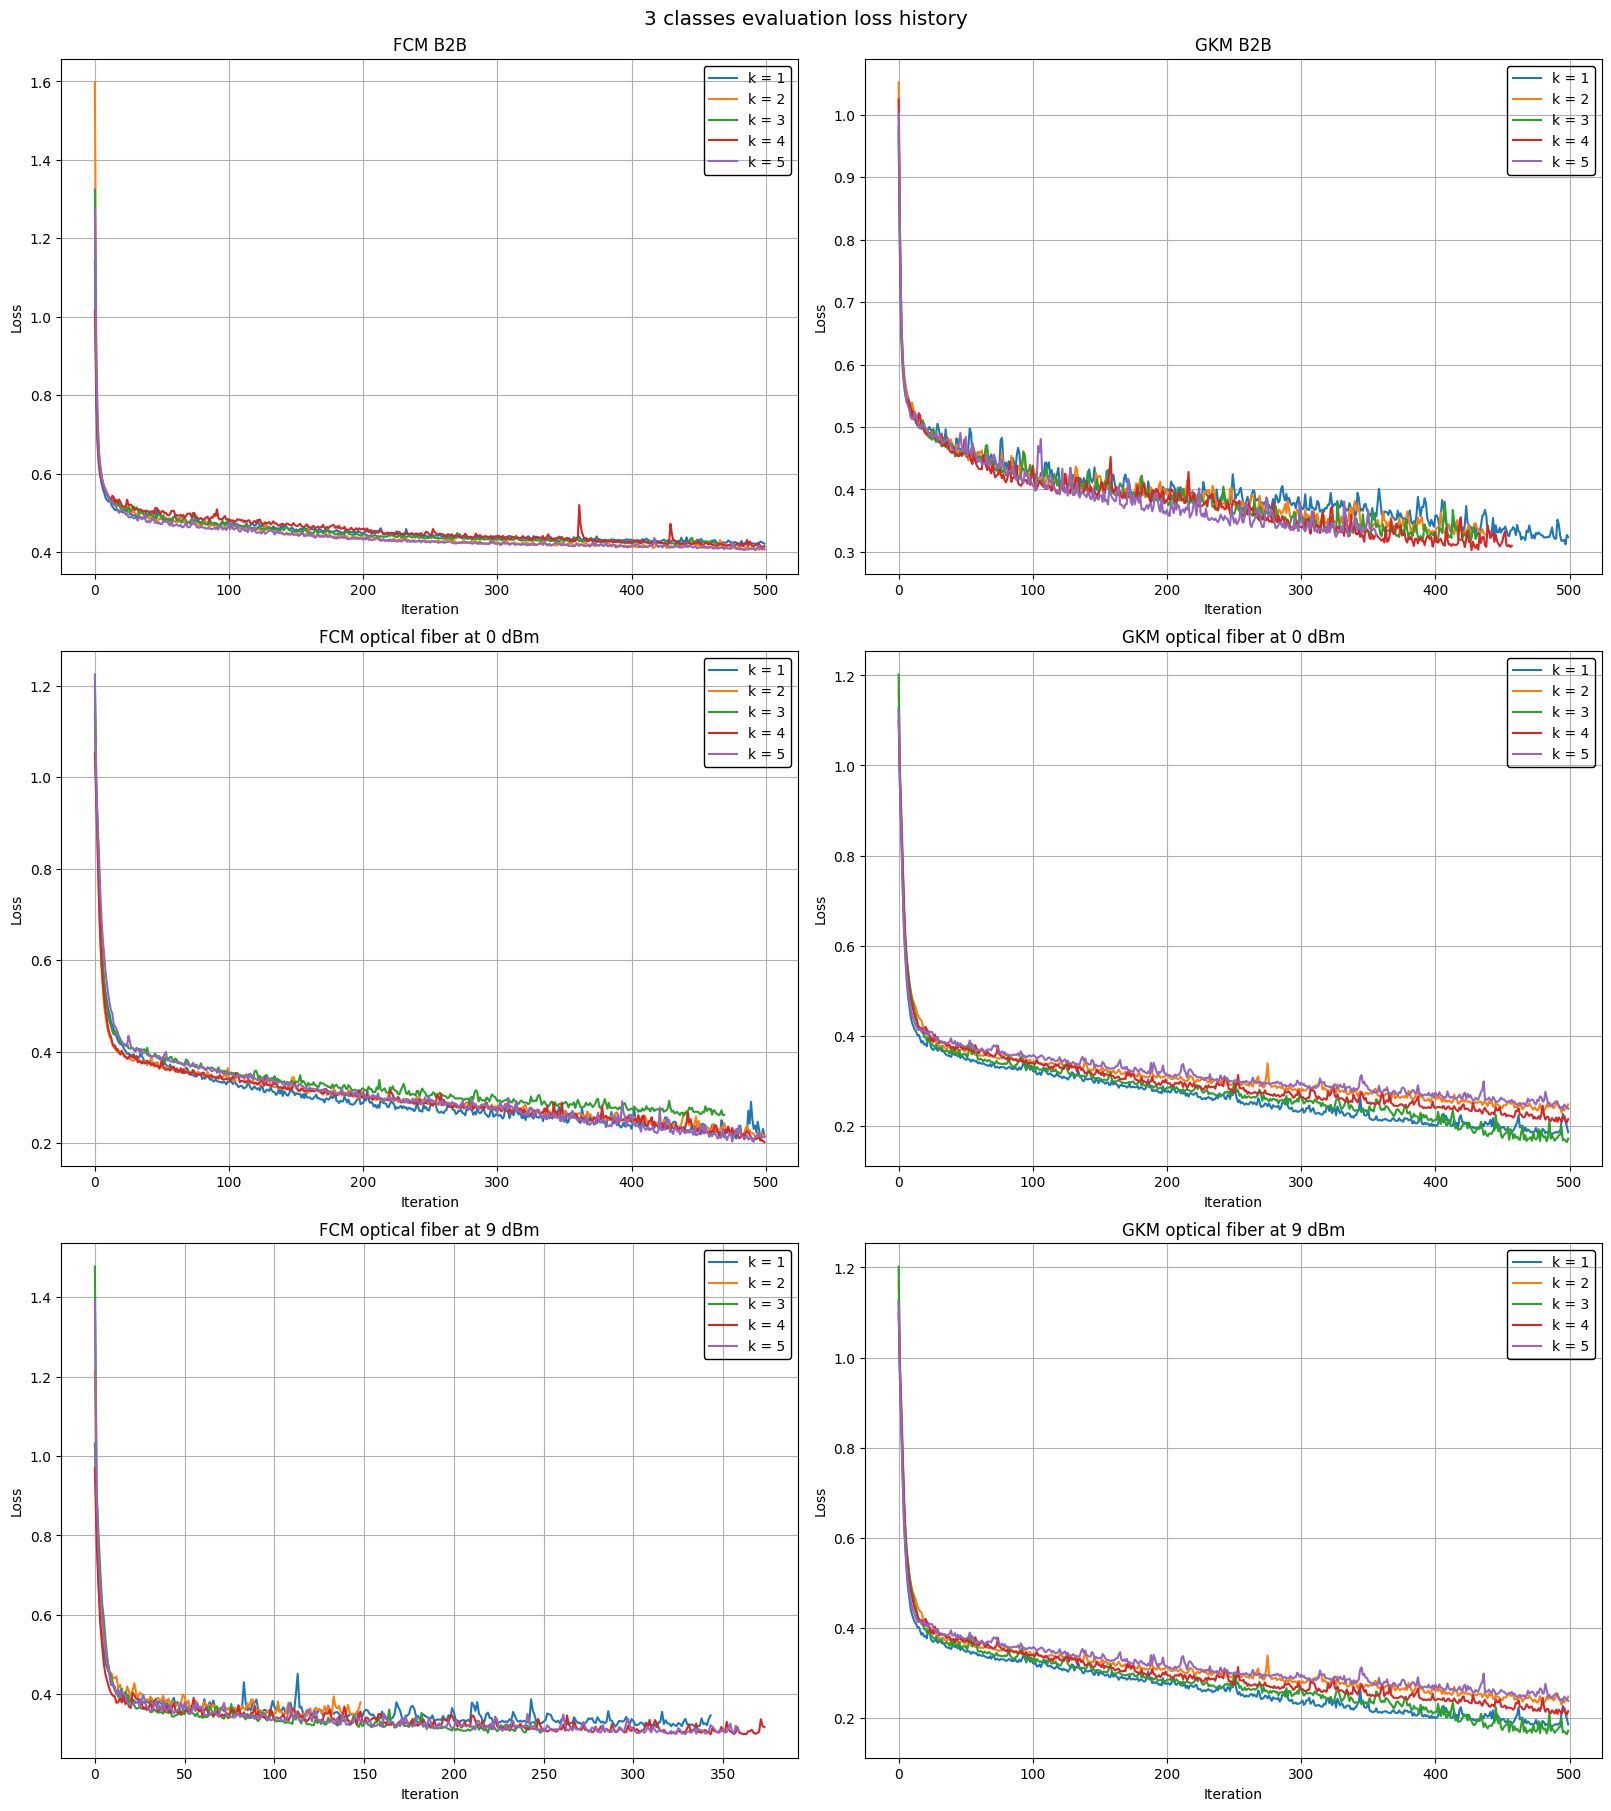

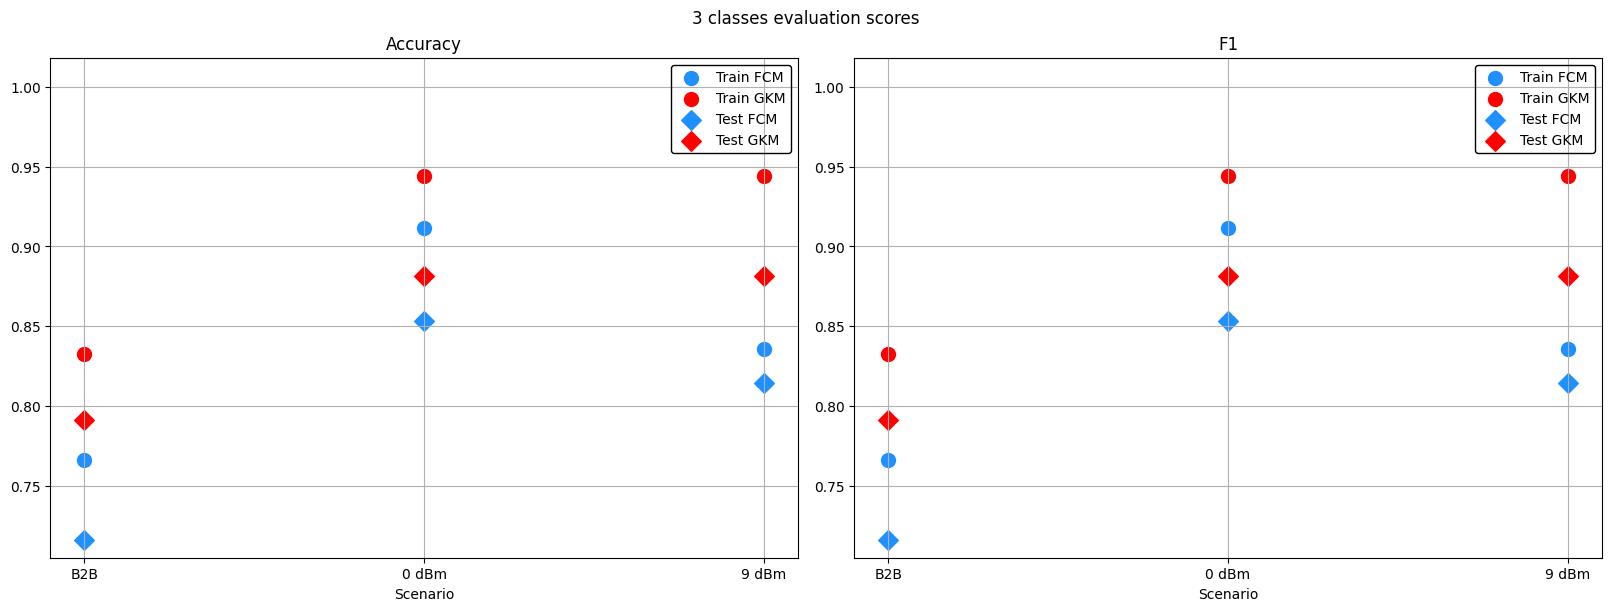

In [150]:
scores = [scores_3classes_FCM_B2B, scores_3classes_GKM_B2B, scores_3classes_FCM_fiber0, scores_3classes_GKM_fiber0, scores_3classes_FCM_fiber9, scores_3classes_GKM_fiber0]
plot_classes_scores(scores, "3 classes evaluation")

## 4 clases

### FCM

In [151]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)]
df_4classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_4classes_FCM_B2B = df_4classes_FCM[0:987, :]
# 0dBm optical fiber
df_4classes_FCM_fiber0 = df_4classes_FCM[988:1520, :]
# 9dBm optical fiber
df_4classes_FCM_fiber9 = df_4classes_FCM[1521:, :]

#### B2B

In [152]:
args = {"data": df_4classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_B2B = calc_once("scores_4classes_FCM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 608
7/7 [==============================] - 0s 1ms/step
Needed iterations: 726
7/7 [==============================] - 0s 894us/step
Needed iterations: 447
7/7 [==============================] - 0s 886us/step
Needed iterations: 566
7/7 [==============================] - 0s 706us/step
Needed iterations: 613
7/7 [==============================] - 0s 918us/step
Time elapsed: 0.63 minutes


#### Fibra óptica a 0dBm

In [153]:
args = {"data": df_4classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_fiber0 = calc_once("scores_4classes_FCM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1055
4/4 [==============================] - 0s 943us/step
Needed iterations: 952
4/4 [==============================] - 0s 949us/step
Needed iterations: 877
4/4 [==============================] - 0s 1ms/step
Needed iterations: 728
4/4 [==============================] - 0s 1ms/step
Needed iterations: 651
4/4 [==============================] - 0s 998us/step
Time elapsed: 0.55 minutes


#### Fibra óptica a 9dBm

In [154]:
args = {"data": df_4classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_fiber9 = calc_once("scores_4classes_FCM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 437
6/6 [==============================] - 0s 851us/step
Needed iterations: 303
6/6 [==============================] - 0s 968us/step
Needed iterations: 500
6/6 [==============================] - 0s 747us/step
Needed iterations: 261
6/6 [==============================] - 0s 834us/step
Needed iterations: 387
6/6 [==============================] - 0s 808us/step
Time elapsed: 0.40 minutes


### GKM

In [155]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)]
df_4classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_4classes_GKM_B2B = df_4classes_GKM[0:987, :]
# 0dBm optical fiber
df_4classes_GKM_fiber0 = df_4classes_GKM[988:1520, :]
# 9dBm optical fiber
df_4classes_GKM_fiber9 = df_4classes_GKM[1521:, :]

#### B2B

In [156]:
args = {"data": df_4classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_B2B = calc_once("scores_4classes_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 246
7/7 [==============================] - 0s 769us/step
Needed iterations: 520
7/7 [==============================] - 0s 1ms/step
Needed iterations: 444
7/7 [==============================] - 0s 954us/step
Needed iterations: 659
7/7 [==============================] - 0s 834us/step
Needed iterations: 294
7/7 [==============================] - 0s 779us/step
Time elapsed: 0.52 minutes


#### Fibra óptica a 0dBm

In [157]:
args = {"data": df_4classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_fiber0 = calc_once("scores_4classes_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1048
4/4 [==============================] - 0s 997us/step
Needed iterations: 971
4/4 [==============================] - 0s 1ms/step
Needed iterations: 1095
4/4 [==============================] - 0s 923us/step
Needed iterations: 994
4/4 [==============================] - 0s 1ms/step
Needed iterations: 1282
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.73 minutes


#### Fibra óptica a 9dBm

In [158]:
args = {"data": df_4classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_fiber9 = calc_once("scores_4classes_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 254
6/6 [==============================] - 0s 827us/step
Needed iterations: 252
6/6 [==============================] - 0s 1ms/step
Needed iterations: 398
6/6 [==============================] - 0s 1ms/step
Needed iterations: 327
6/6 [==============================] - 0s 880us/step
Needed iterations: 401
6/6 [==============================] - 0s 1ms/step
Time elapsed: 0.35 minutes


In [159]:
%store scores_4classes_FCM_B2B
%store scores_4classes_GKM_B2B
%store scores_4classes_FCM_fiber0
%store scores_4classes_GKM_fiber0
%store scores_4classes_FCM_fiber9
%store scores_4classes_GKM_fiber9

Stored 'scores_4classes_FCM_B2B' (dict)
Stored 'scores_4classes_GKM_B2B' (dict)
Stored 'scores_4classes_FCM_fiber0' (dict)
Stored 'scores_4classes_GKM_fiber0' (dict)
Stored 'scores_4classes_FCM_fiber9' (dict)
Stored 'scores_4classes_GKM_fiber9' (dict)


### Gráficas

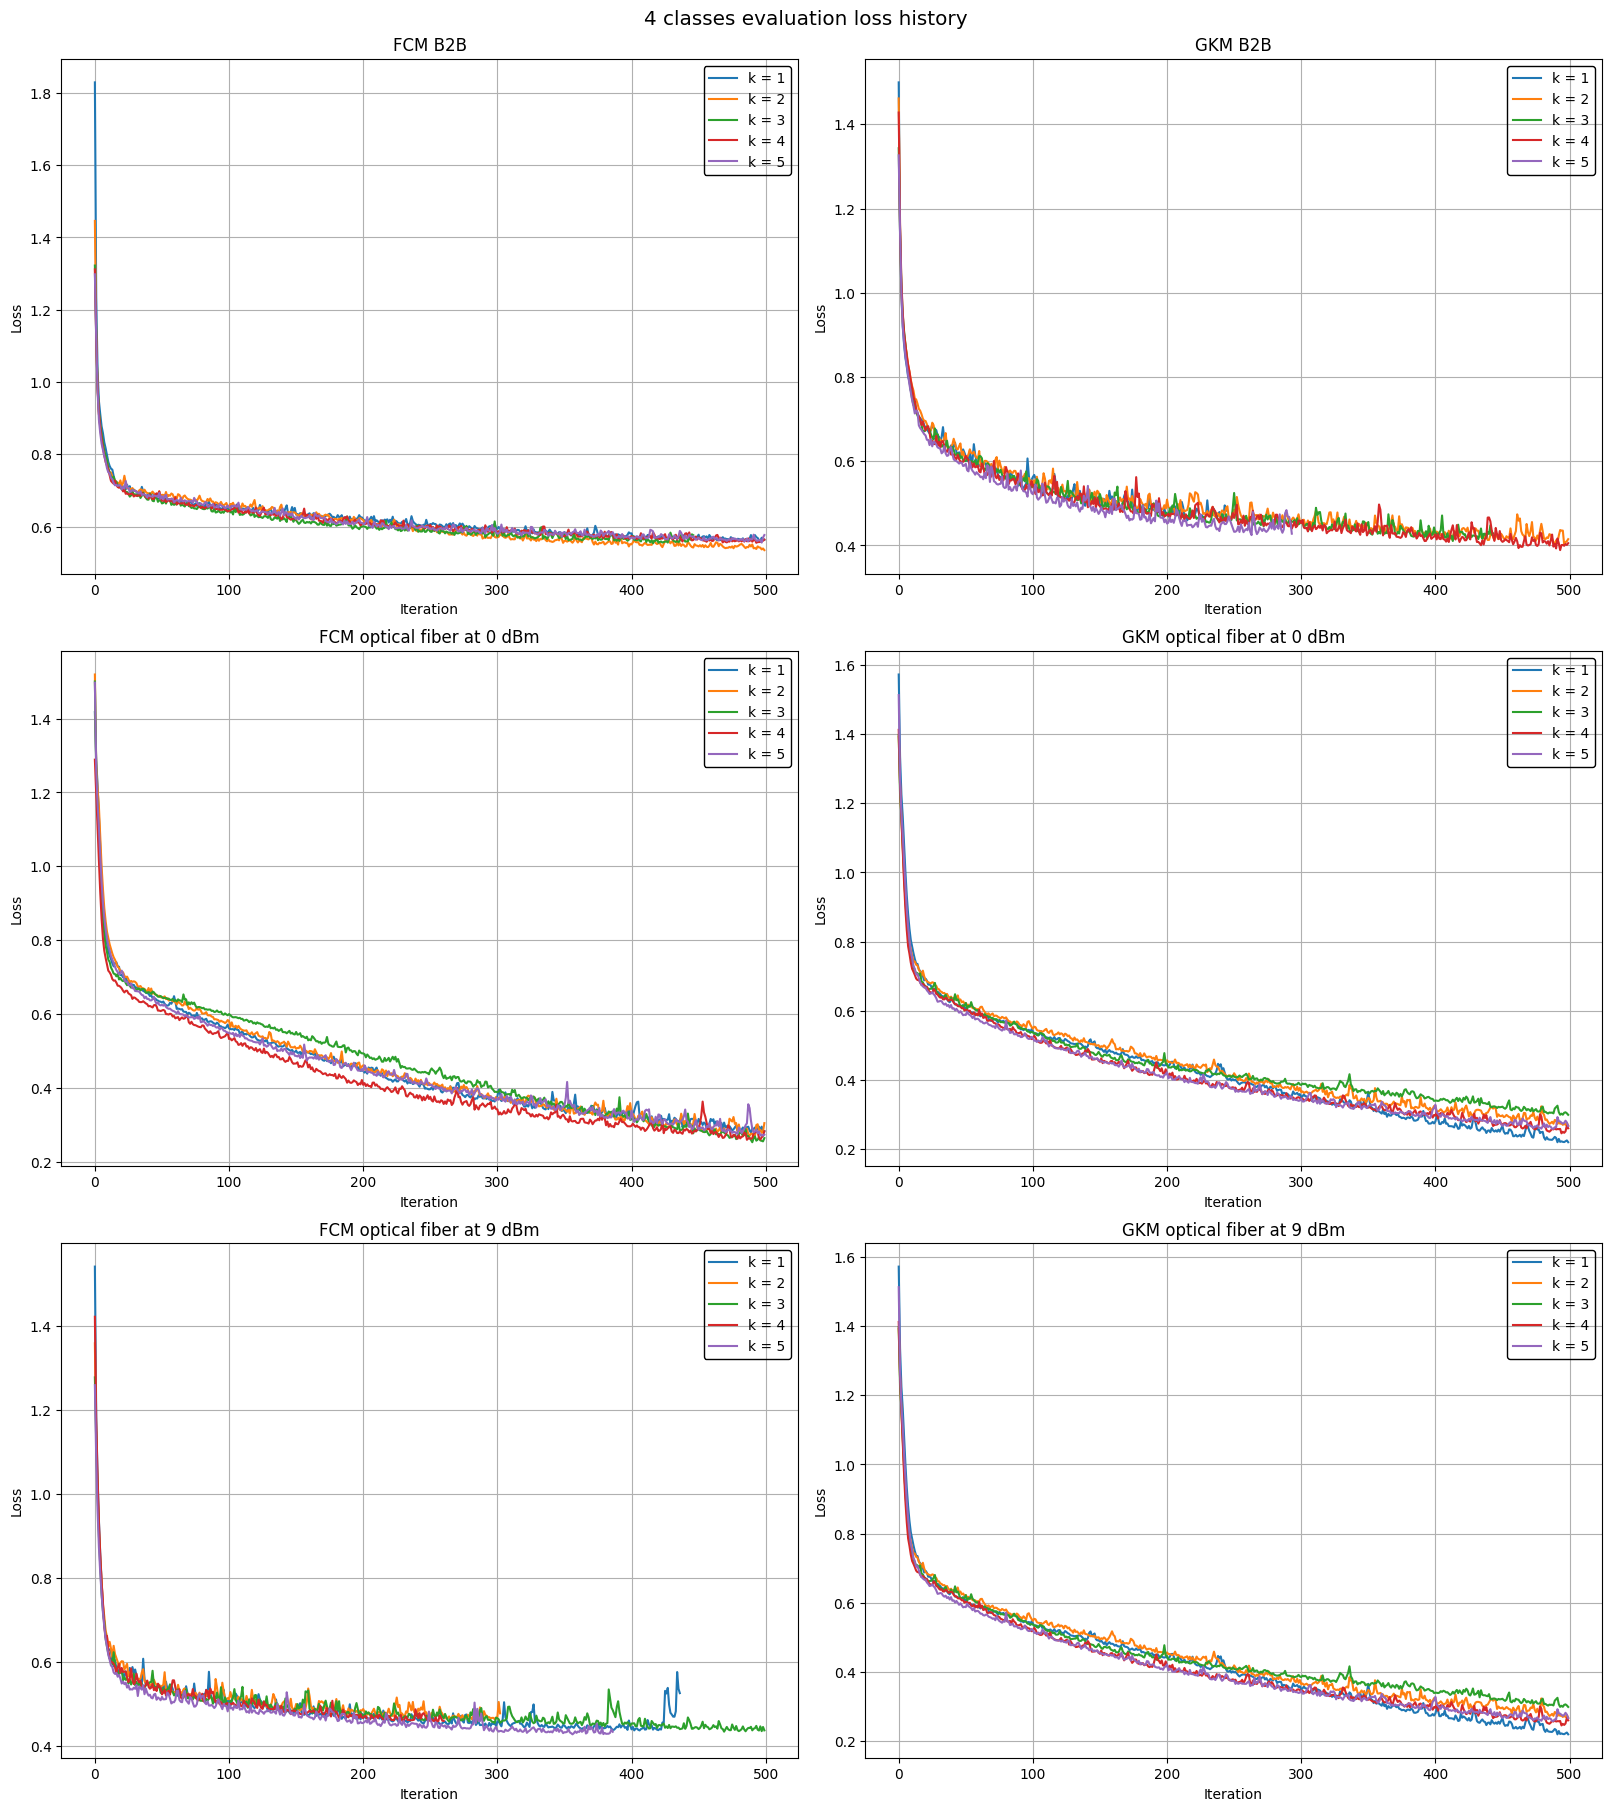

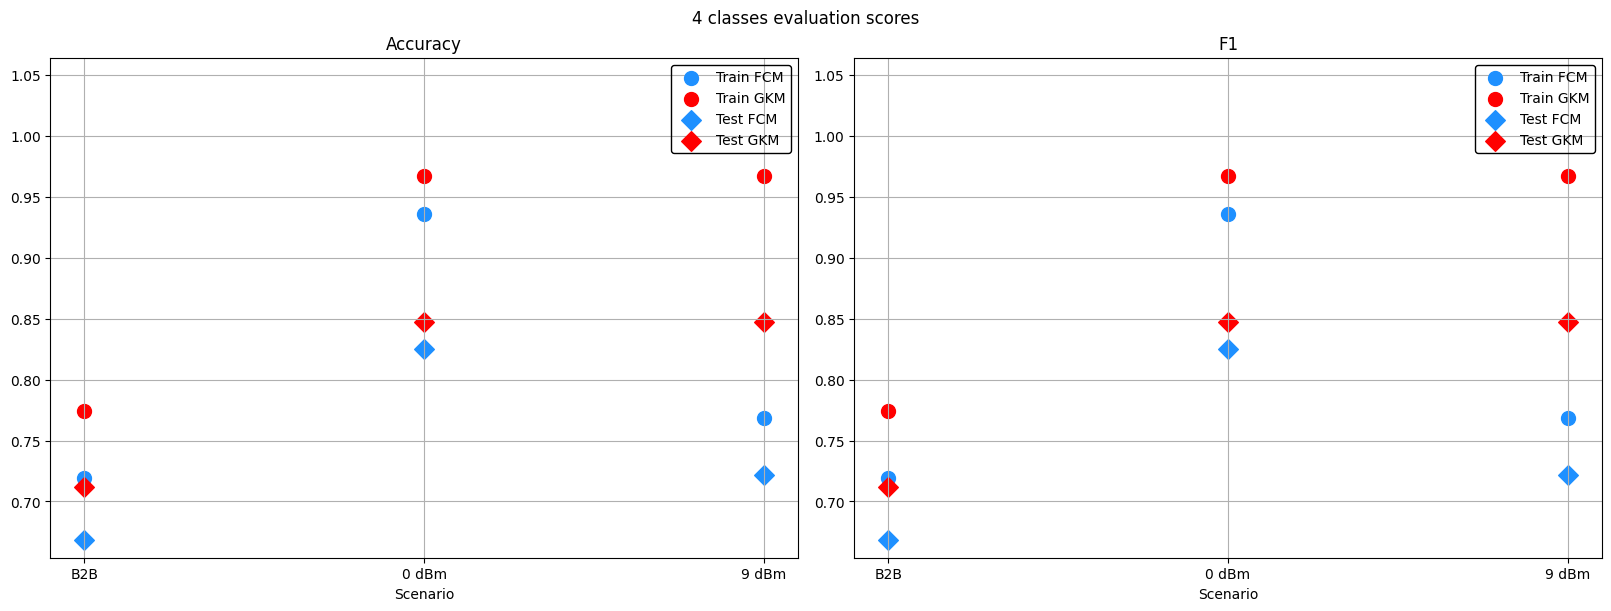

In [160]:
scores = [scores_4classes_FCM_B2B, scores_4classes_GKM_B2B, scores_4classes_FCM_fiber0, scores_4classes_GKM_fiber0, scores_4classes_FCM_fiber9, scores_4classes_GKM_fiber0]
plot_classes_scores(scores, "4 classes evaluation")

## 5 clases

### FCM

In [161]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]
df_5classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_5classes_FCM_B2B = df_5classes_FCM[0:987, :]
# 0dBm optical fiber
df_5classes_FCM_fiber0 = df_5classes_FCM[988:1520, :]
# 9dBm optical fiber
df_5classes_FCM_fiber9 = df_5classes_FCM[1521:, :]

#### B2B

In [162]:
args = {"data": df_5classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_B2B = calc_once("scores_5classes_FCM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 360
7/7 [==============================] - 0s 895us/step
Needed iterations: 466
7/7 [==============================] - 0s 1ms/step
Needed iterations: 386
7/7 [==============================] - 0s 767us/step
Needed iterations: 477
7/7 [==============================] - 0s 1ms/step
Needed iterations: 643
7/7 [==============================] - 0s 784us/step
Time elapsed: 0.51 minutes


#### Fibra óptica a 0dBm

In [163]:
args = {"data": df_5classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_fiber0 = calc_once("scores_5classes_FCM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1000
4/4 [==============================] - 0s 1ms/step
Needed iterations: 597
4/4 [==============================] - 0s 864us/step
Needed iterations: 631
4/4 [==============================] - 0s 1ms/step
Needed iterations: 777
4/4 [==============================] - 0s 936us/step
Needed iterations: 954
4/4 [==============================] - 0s 959us/step
Time elapsed: 0.52 minutes


#### Fibra óptica a 9dBm

In [164]:
args = {"data": df_5classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_fiber9 = calc_once("scores_5classes_FCM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 436
6/6 [==============================] - 0s 986us/step
Needed iterations: 251
6/6 [==============================] - 0s 933us/step
Needed iterations: 504
6/6 [==============================] - 0s 877us/step
Needed iterations: 290
6/6 [==============================] - 0s 1ms/step
Needed iterations: 331
6/6 [==============================] - 0s 875us/step
Time elapsed: 0.38 minutes


### GKM

In [165]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]
df_5classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_5classes_GKM_B2B = df_5classes_GKM[0:987, :]
# 0dBm optical fiber
df_5classes_GKM_fiber0 = df_5classes_GKM[988:1520, :]
# 9dBm optical fiber
df_5classes_GKM_fiber9 = df_5classes_GKM[1521:, :]

#### B2B

In [166]:
args = {"data": df_5classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_B2B = calc_once("scores_5classes_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 297
7/7 [==============================] - 0s 773us/step
Needed iterations: 493
7/7 [==============================] - 0s 1ms/step
Needed iterations: 367
7/7 [==============================] - 0s 768us/step
Needed iterations: 430
7/7 [==============================] - 0s 759us/step
Needed iterations: 588
7/7 [==============================] - 0s 819us/step
Time elapsed: 0.49 minutes


#### Fibra óptica a 0dBm

In [167]:
args = {"data": df_5classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_fiber0 = calc_once("scores_5classes_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1272
4/4 [==============================] - 0s 1ms/step
Needed iterations: 912
4/4 [==============================] - 0s 936us/step
Needed iterations: 585
4/4 [==============================] - 0s 919us/step
Needed iterations: 908
4/4 [==============================] - 0s 900us/step
Needed iterations: 905
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.59 minutes


#### Fibra óptica a 9dBm

In [168]:
args = {"data": df_5classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_fiber9 = calc_once("scores_5classes_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 251
6/6 [==============================] - 0s 869us/step
Needed iterations: 215
6/6 [==============================] - 0s 829us/step
Needed iterations: 345
6/6 [==============================] - 0s 805us/step
Needed iterations: 312
6/6 [==============================] - 0s 1ms/step
Needed iterations: 399
6/6 [==============================] - 0s 826us/step
Time elapsed: 0.34 minutes


In [169]:
%store scores_5classes_FCM_B2B
%store scores_5classes_GKM_B2B
%store scores_5classes_FCM_fiber0
%store scores_5classes_GKM_fiber0
%store scores_5classes_FCM_fiber9
%store scores_5classes_GKM_fiber9

Stored 'scores_5classes_FCM_B2B' (dict)
Stored 'scores_5classes_GKM_B2B' (dict)
Stored 'scores_5classes_FCM_fiber0' (dict)
Stored 'scores_5classes_GKM_fiber0' (dict)
Stored 'scores_5classes_FCM_fiber9' (dict)
Stored 'scores_5classes_GKM_fiber9' (dict)


### Gráficas

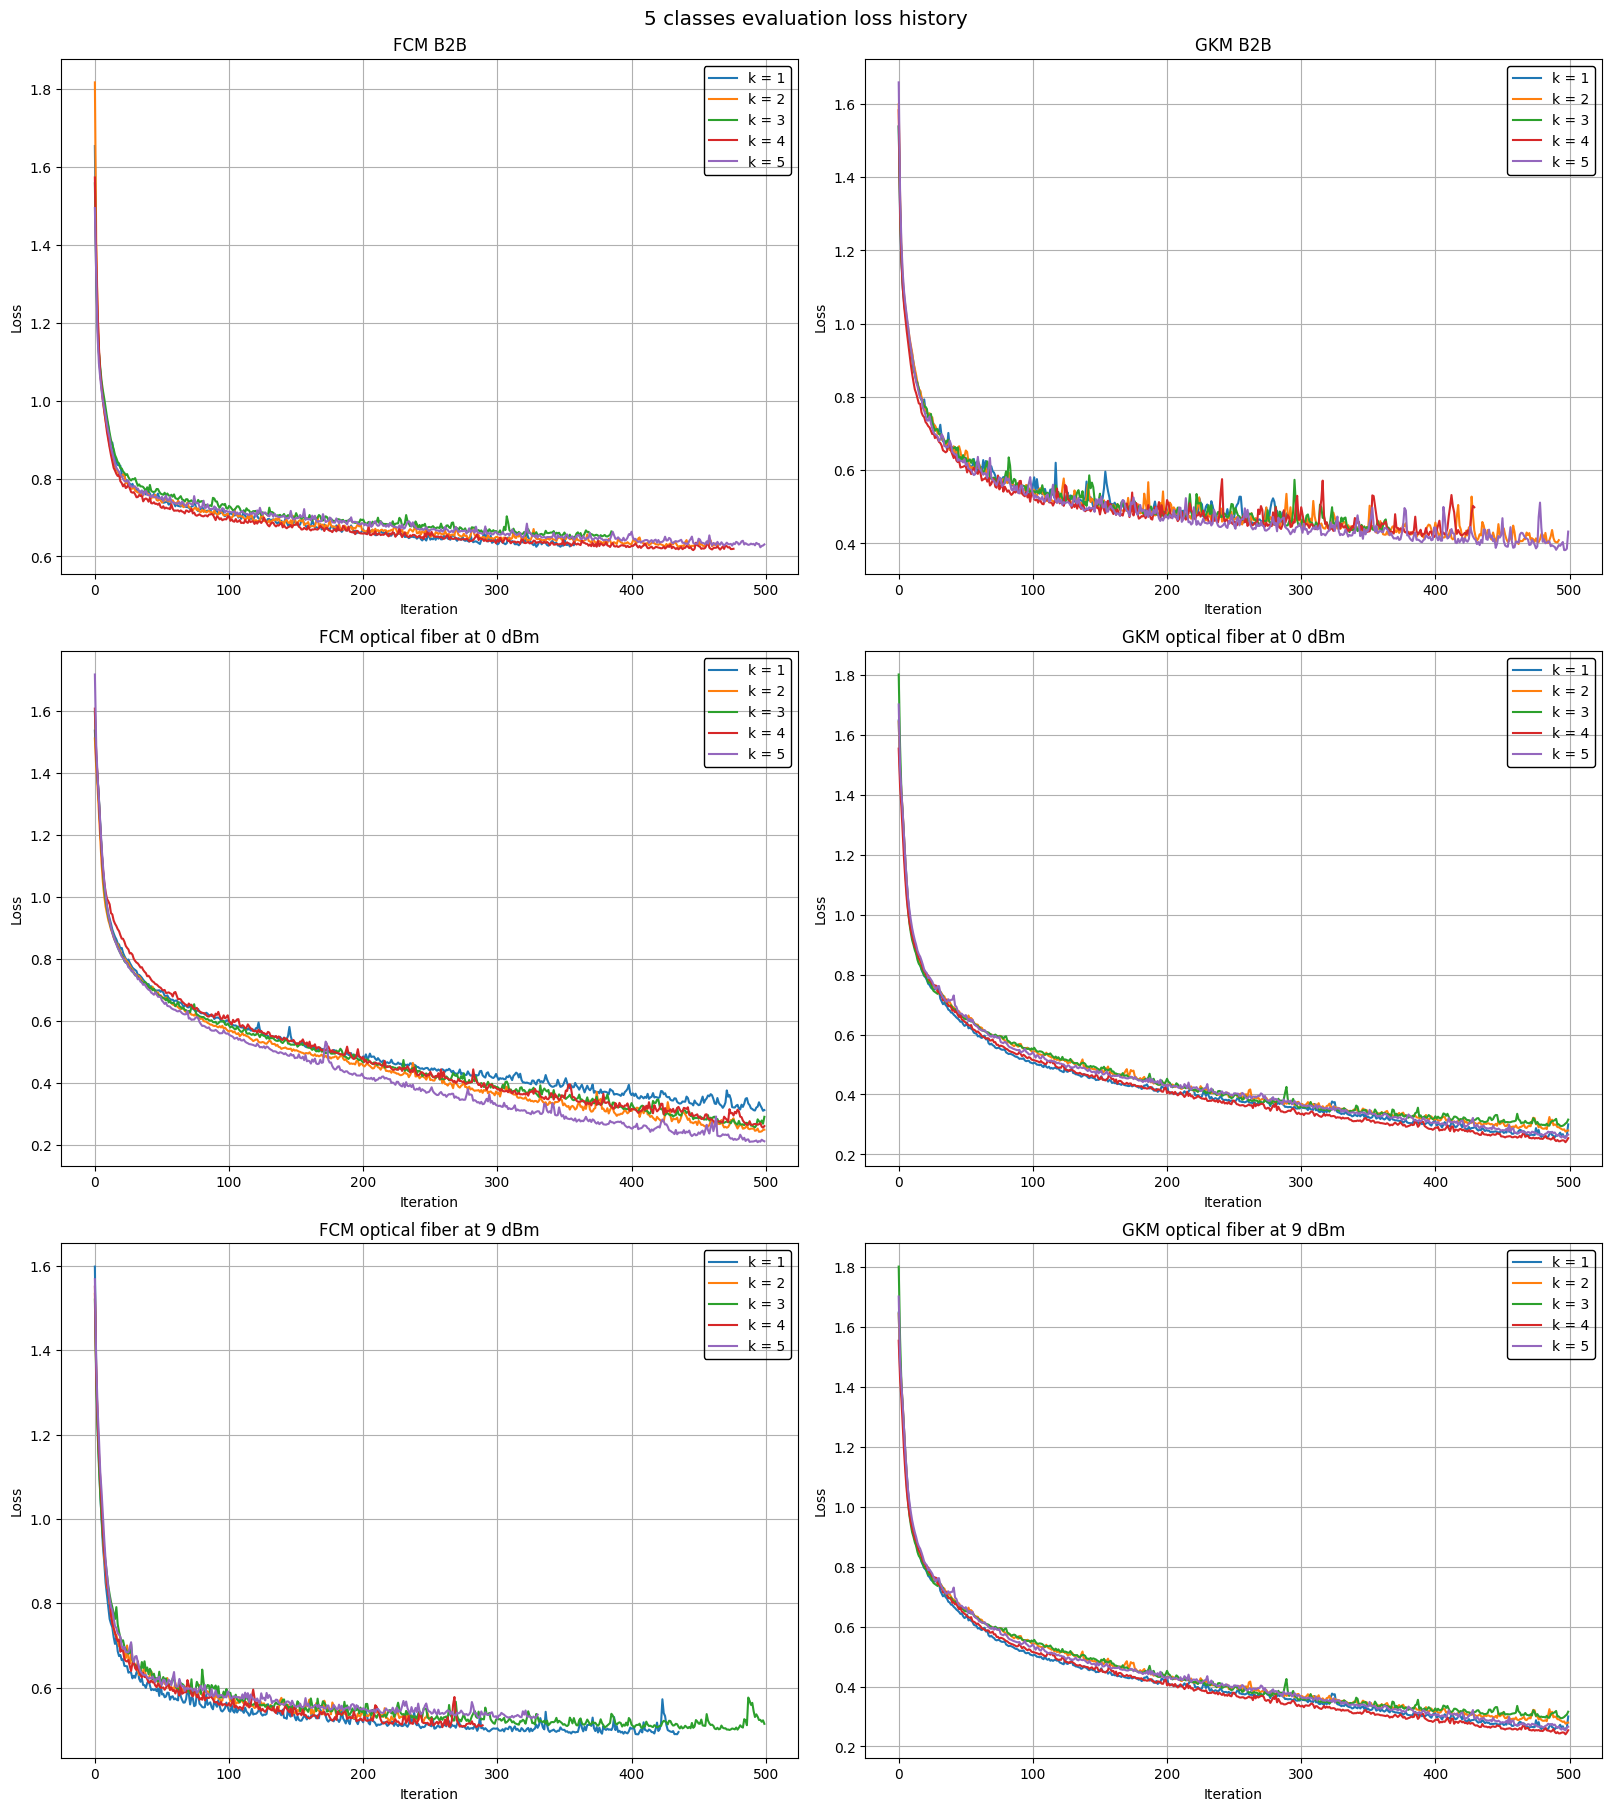

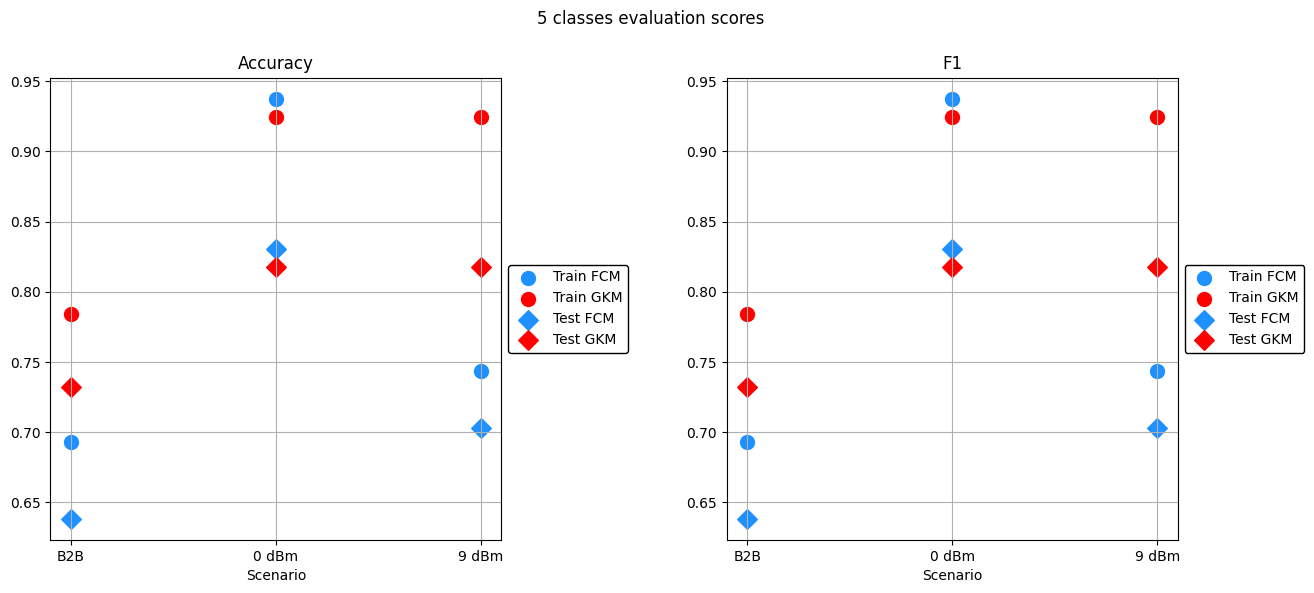

In [175]:
scores = [scores_5classes_FCM_B2B, scores_5classes_GKM_B2B, scores_5classes_FCM_fiber0, scores_5classes_GKM_fiber0, scores_5classes_FCM_fiber9, scores_5classes_GKM_fiber0]
plot_classes_scores(scores, "5 classes evaluation")

In [171]:
scores = [scores_2classes_FCM_B2B, scores_3classes_FCM_B2B, scores_4classes_FCM_B2B, scores_5classes_FCM_B2B]
scores_classes_FCM_B2B = [float(np.average(score_classes_FCM_B2B.get("acc").get("test"))) for score_classes_FCM_B2B in scores]

scores = [scores_2classes_FCM_fiber0, scores_3classes_FCM_fiber0, scores_4classes_FCM_fiber0, scores_5classes_FCM_fiber0]
scores_classes_FCM_fiber0 = [float(np.average(score_classes_FCM_fiber0.get("acc").get("test"))) for score_classes_FCM_fiber0 in scores]

scores = [scores_2classes_FCM_fiber9, scores_3classes_FCM_fiber9, scores_4classes_FCM_fiber9, scores_5classes_FCM_fiber9]
scores_classes_FCM_fiber9 = [float(np.average(score_classes_FCM_fiber9.get("acc").get("test"))) for score_classes_FCM_fiber9 in scores]

classifier_FCM_df = pl.DataFrame(
        {"Classes": range(2, 6), "B2B": scores_classes_FCM_B2B, "Fiber @ 0dBm": scores_classes_FCM_fiber0, "Fiber @ 9dBm": scores_classes_FCM_fiber9}
    )

classifier_FCM_df

Classes,B2B,Fiber @ 0dBm,Fiber @ 9dBm
i64,f64,f64,f64
2,0.709173,0.876107,0.815273
3,0.716356,0.853518,0.814188
4,0.668738,0.825145,0.721805
5,0.638322,0.830771,0.70278


In [172]:
scores = [scores_2classes_GKM_B2B, scores_3classes_GKM_B2B, scores_4classes_GKM_B2B, scores_5classes_GKM_B2B]
scores_classes_GKM_B2B = [float(np.average(score_classes_GKM_B2B.get("acc").get("test"))) for score_classes_GKM_B2B in scores]

scores = [scores_2classes_GKM_fiber0, scores_3classes_GKM_fiber0, scores_4classes_GKM_fiber0, scores_5classes_GKM_fiber0]
scores_classes_GKM_fiber0 = [float(np.average(score_classes_GKM_fiber0.get("acc").get("test"))) for score_classes_GKM_fiber0 in scores]

scores = [scores_2classes_GKM_fiber9, scores_3classes_GKM_fiber9, scores_4classes_GKM_fiber9, scores_5classes_GKM_fiber9]
scores_classes_GKM_fiber9 = [float(np.average(score_classes_GKM_fiber9.get("acc").get("test"))) for score_classes_GKM_fiber9 in scores]

classifier_GKM_df = pl.DataFrame(
        {"Classes": range(2, 6), "B2B": scores_classes_GKM_B2B, "Fiber @ 0dBm": scores_classes_GKM_fiber0, "Fiber @ 9dBm": scores_classes_GKM_fiber9}
    )

classifier_GKM_df

Classes,B2B,Fiber @ 0dBm,Fiber @ 9dBm
i64,f64,f64,f64
2,0.772015,0.926715,0.882937
3,0.791263,0.881555,0.879528
4,0.712208,0.847734,0.818682
5,0.732503,0.817704,0.808563
